# 1.0 DATA PREPARATION

In [1]:
import pandas as pd
import numpy as np
import joblib
import plotnine as pn
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
pn.options.dpi = 300

In [3]:
cdnow_raw_df = pd.read_csv('../data/cdnow.csv', index_col=0)

In [4]:
cdnow_raw_df.head(3)

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00


In [5]:
cdnow_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  69659 non-null  int64  
 1   date         69659 non-null  object 
 2   quantity     69659 non-null  int64  
 3   price        69659 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.7+ MB


In [6]:
# convert to datetime
cdnow_df = (
    cdnow_raw_df
    .assign(date=lambda x: pd.to_datetime(x['date']))
    .dropna() 
)

In [7]:
cdnow_df['date'].dtype

dtype('<M8[ns]')

# 2.0 COHORT ANALYSIS

Only customers that have joined at the specific business day

## Get Range of Initial Purchases

In [8]:
cdnow_first_purchase_tbl = (
    cdnow_df
    .sort_values(['customer_id','date'])
    .groupby('customer_id')
    .first()
                            )

In [9]:
cdnow_first_purchase_tbl.head()

,date,quantity,price
customer_id,,,
1,1997-01-01,1,11.77
2,1997-01-12,1,12.00
3,1997-01-02,2,20.76
4,1997-01-01,2,29.33
5,1997-01-01,2,29.33


In [10]:
cdnow_first_purchase_tbl['date'].min()

Timestamp('1997-01-01 00:00:00')

In [11]:
cdnow_first_purchase_tbl['date'].max()

Timestamp('1997-03-25 00:00:00')

## Visualize: All purchases within cohort

<Axes: xlabel='date'>

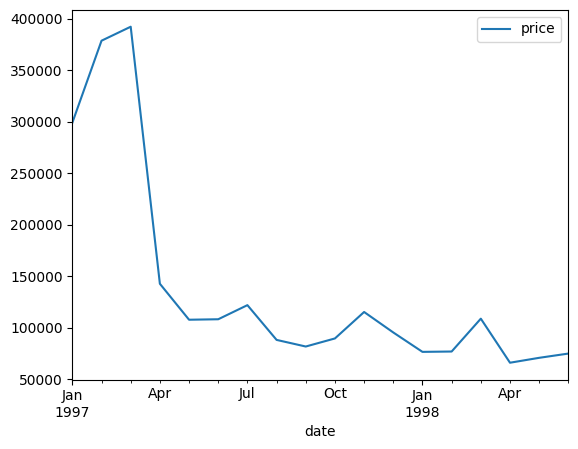

In [12]:
cdnow_df.reset_index() \
    .set_index('date') \
    [['price']] \
    .resample(rule='MS') \
    .sum() \
    .plot()

## Visualize: Individual Customer Purchases

In [13]:
# Select a subset of customer IDs
ids = cdnow_df['customer_id'].unique()
ids_selected = ids[:12]

/tmp/ipykernel_2698/2476615928.py:26: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/home/blackitalian/miniconda3/envs/cdnow/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/home/blackitalian/miniconda3/envs/cdnow/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/home/blackitalian/miniconda3/envs/cdnow/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/home/blackitalian/miniconda3/envs/cdnow/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observat

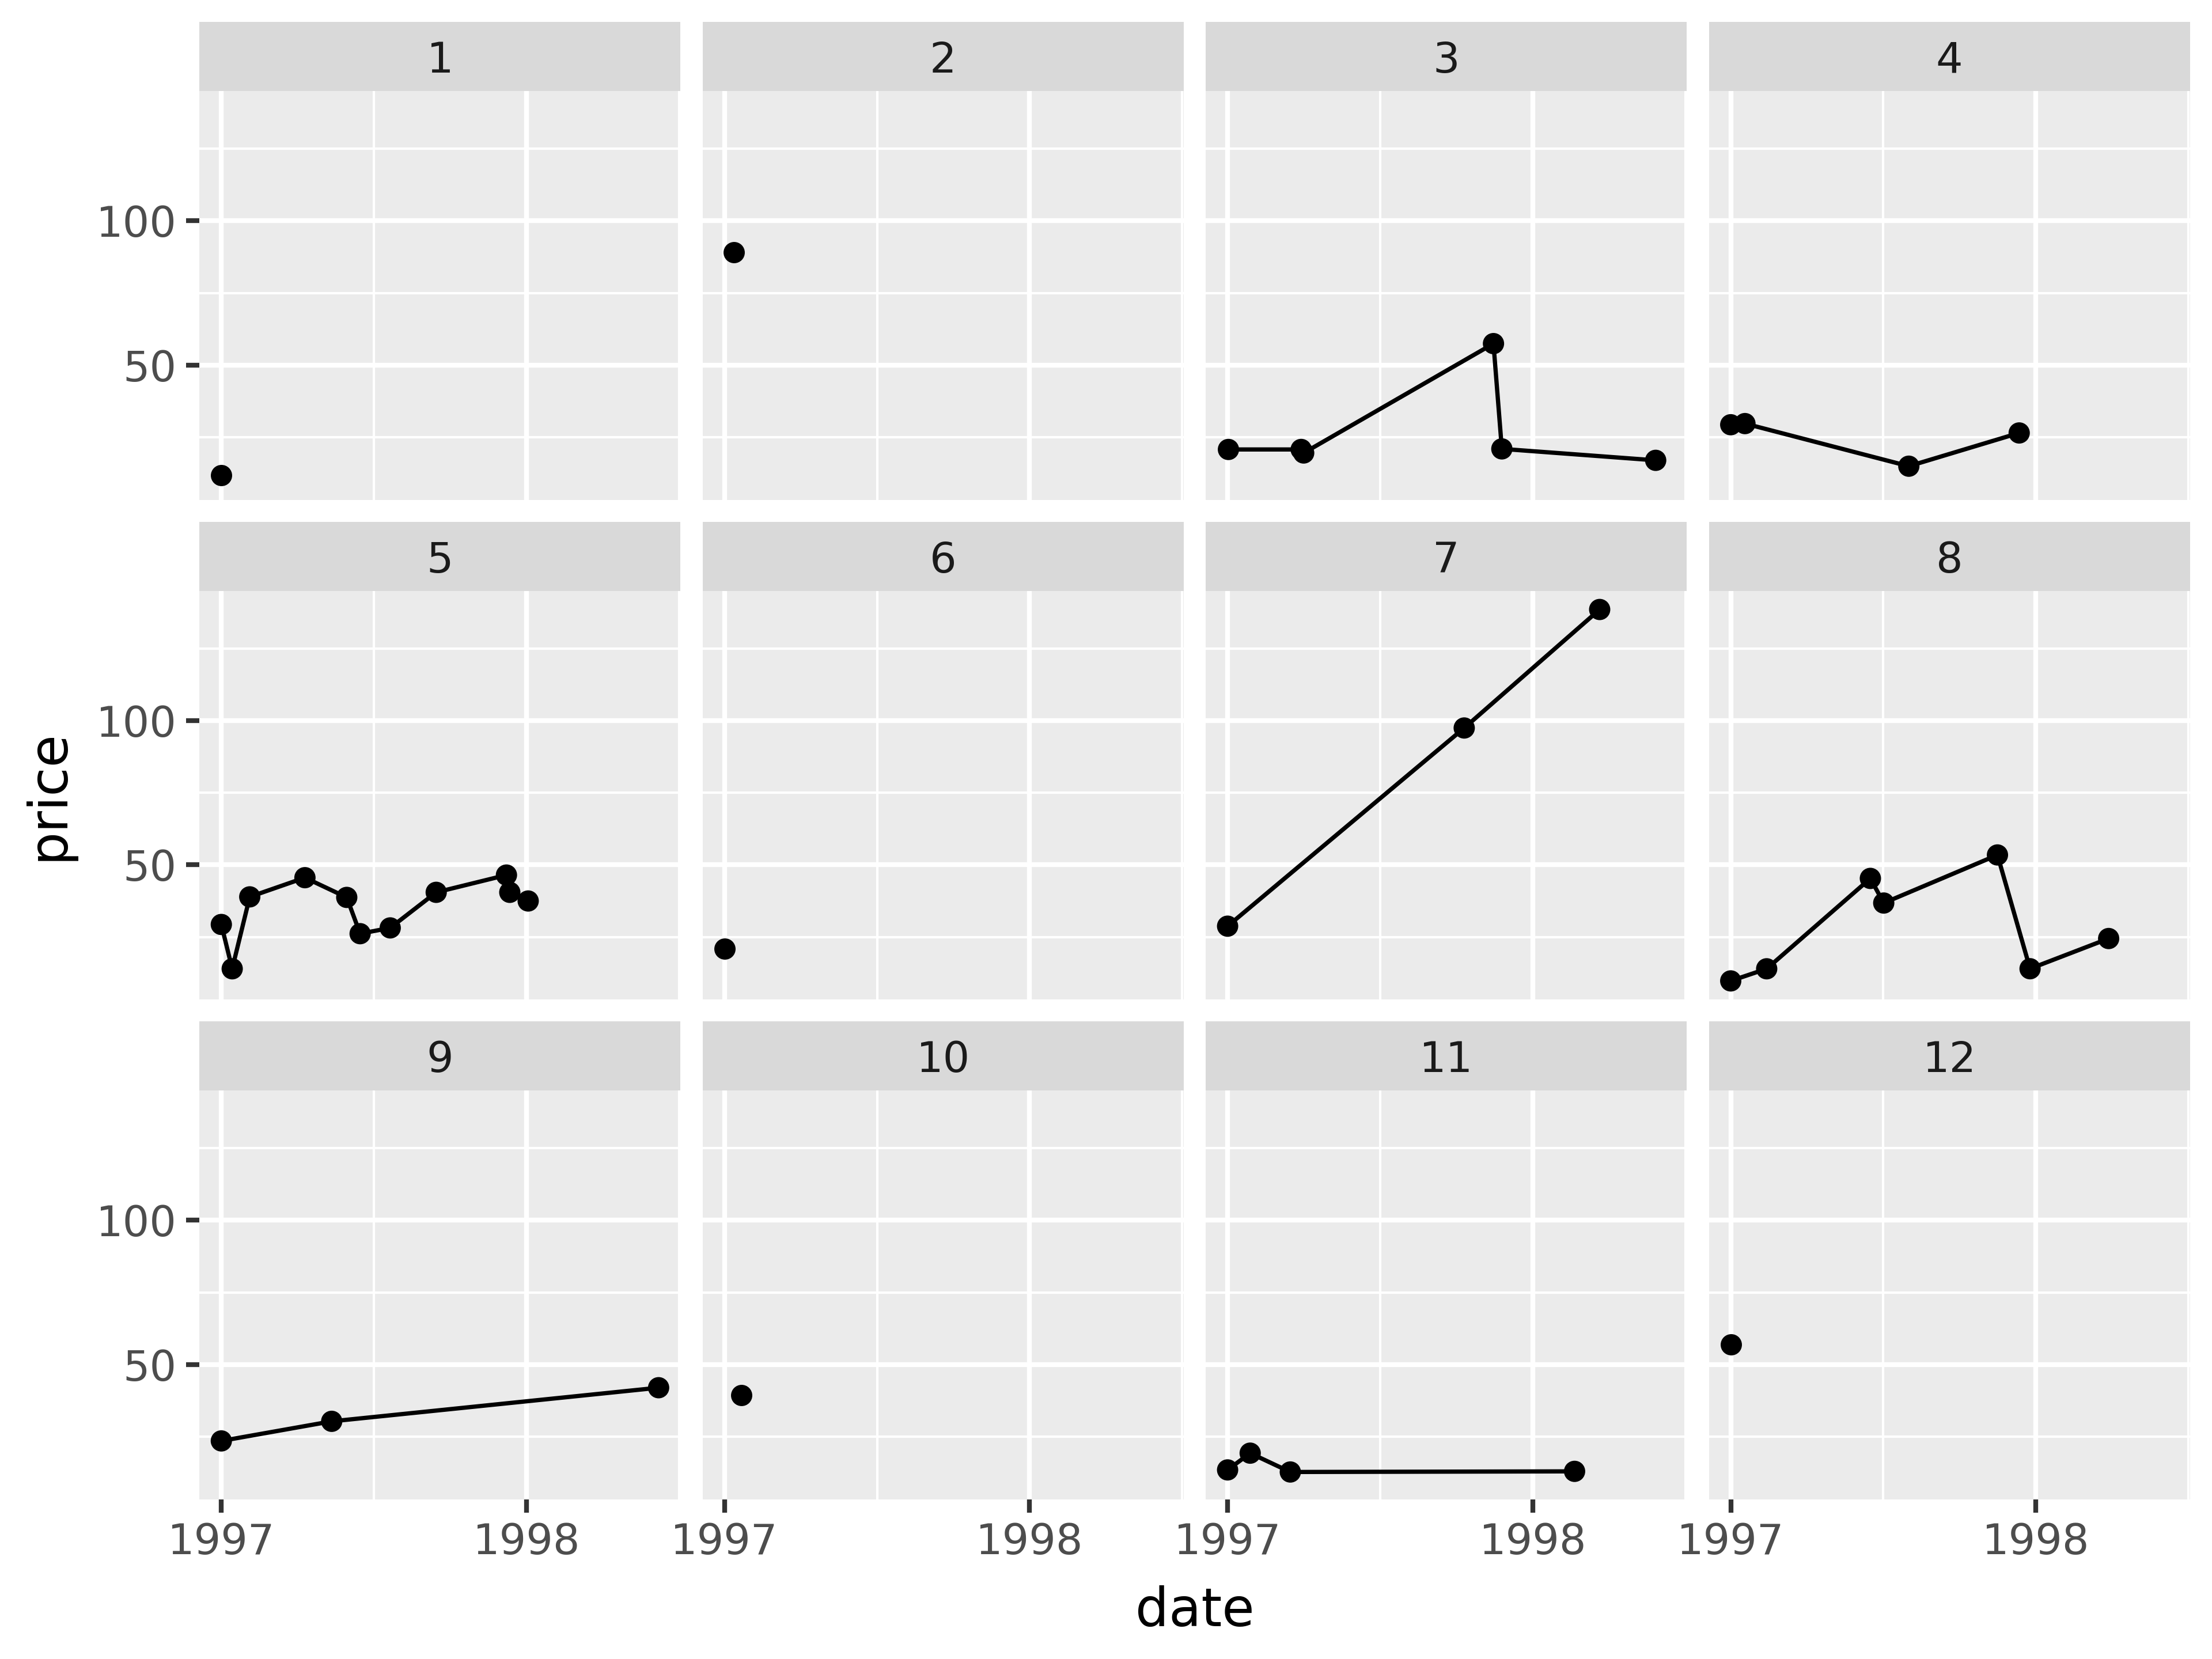

In [14]:
# ggplot API
# Filter the DataFrame for the selected customer IDs
cdnow_cust_id_subset_df = (
    cdnow_df[cdnow_df['customer_id'].isin(ids_selected)]
    .groupby(['customer_id', 'date'])
    .sum()
    .reset_index()
)

# Create the plot
plot = (
    pn.ggplot(
        cdnow_cust_id_subset_df,
        pn.aes('date', 'price', group='customer_id')
    )
    + pn.geom_line()
    + pn.geom_point()
    + pn.facet_wrap('~customer_id')
    + pn.scale_x_date(
        date_breaks='1 year',
        date_labels='%Y'
    )
)

# Display the plot
print(plot)

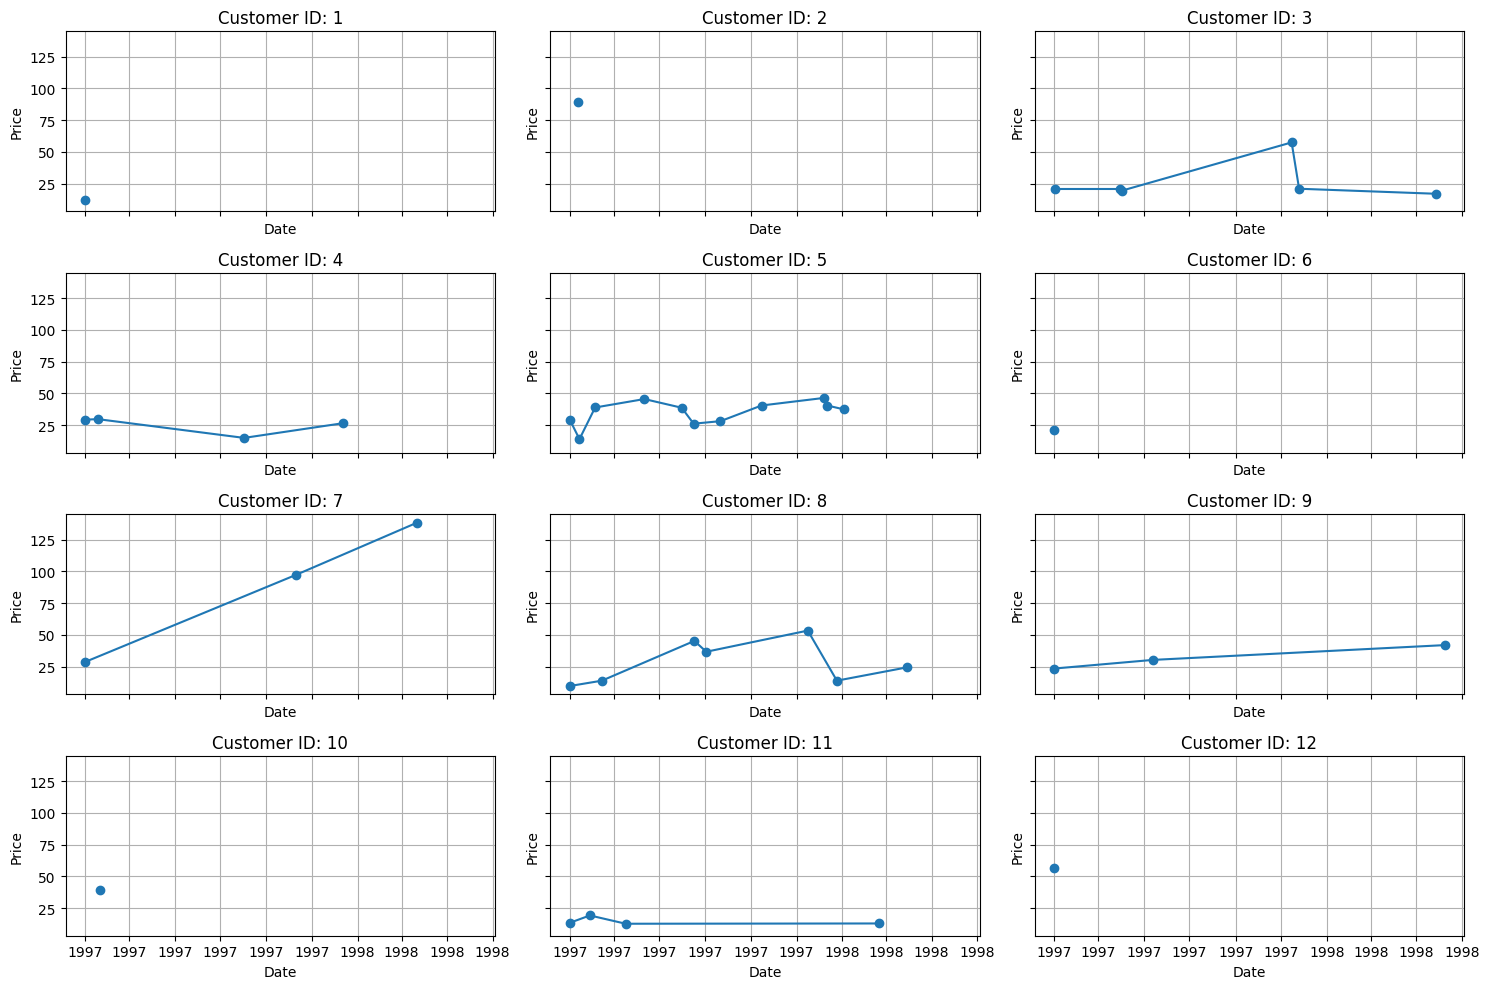

In [15]:
# Number of unique customers in the subset
unique_customers = cdnow_cust_id_subset_df['customer_id'].nunique()

# Define the number of rows and columns for the subplots
num_cols = 3
num_rows = (unique_customers + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for ax, (customer_id, group) in zip(axes, cdnow_cust_id_subset_df.groupby('customer_id')):
    ax.plot(group['date'], group['price'], marker='o', linestyle='-')
    ax.set_title(f'Customer ID: {customer_id}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
    ax.grid(True) 

# Remove any empty subplots
for i in range(unique_customers, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()



# 3.0 FEATURE ENGINEERING

Frame problem:

- What will the customers spend in the next 90-days? (Regression)
- What is the probability of a customer to make a purchase in the next 90-days? (Classification)

## 3.1 TIME SPLITTING (STAGE 1)

In [16]:
n_days = 90
max_date = cdnow_df['date'].max()

# Calculate the cutoff date
cutoff = max_date - pd.to_timedelta(n_days, unit='d')

In [17]:
temporal_in_df = cdnow_df[cdnow_df['date'] <= cutoff]
temporal_out_df = cdnow_df[cdnow_df['date'] > cutoff]

In [18]:
temporal_in_df.head(3)

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00


In [19]:
temporal_out_df.head(3)

,customer_id,date,quantity,price
8,3,1998-05-28,1,16.99
38,9,1998-06-08,2,41.98
68,25,1998-04-17,1,12.99


## 3.2 FEATURE ENGINEERING (RFM)

### Make Targets From Data

In [20]:
targets_df = (
    temporal_out_df
    .drop(['quantity','date'], axis=1) # must drop date to .sum()
    .groupby('customer_id')
    .sum()
    .rename({'price': 'spend_90_total'}, axis=1)
    .assign(spend_90_flag=1)  # Add a new column 'spend_90_flag' with value 1
)

In [21]:
targets_df.head(3)

,spend_90_total,spend_90_flag
customer_id,,
3,16.99,1
9,41.98,1
25,73.43,1


In [22]:
# From almost 70k to 3301
targets_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3301 entries, 3 to 23561
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   spend_90_total  3301 non-null   float64
 1   spend_90_flag   3301 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 77.4 KB


### Make Recency (Date) Features From 'in' Data

In [23]:
max_date = temporal_in_df['date'].max()

In [24]:
recency_features_df = (
    temporal_in_df
    #.drop(['quantity','price'], axis=1)
    [['customer_id','date']]
    .groupby('customer_id')
    .apply(lambda x: (x['date'].max() - max_date).days, include_groups=False)
    .to_frame(name='recency') # <- cause customer_id to become index
    .set_axis(['recency'], axis=1)
)

In [25]:
recency_features_df.head(3)

,recency
customer_id,
1,-455
2,-444
3,-127


In [26]:
recency_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23570 entries, 1 to 23570
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   recency  23570 non-null  int64
dtypes: int64(1)
memory usage: 368.3 KB


### Make Frequency (Count) Features From 'in' Data

In [27]:
frequency_features_df = (
    temporal_in_df[['customer_id','date']]
    .groupby('customer_id')
    .count()
    .set_axis(['frequency'], axis=1)
)

In [28]:
frequency_features_df.head()

,frequency
customer_id,
1,1
2,2
3,5
4,4
5,11


In [29]:
frequency_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23570 entries, 1 to 23570
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   frequency  23570 non-null  int64
dtypes: int64(1)
memory usage: 368.3 KB


### Make Price (Monetary) Features From 'in' Data

In [30]:
price_features_df = (
    temporal_in_df
    .groupby('customer_id')
    .aggregate({'price':['sum','mean']})
    .set_axis(['price_sum','price_mean'], axis=1)
)

In [31]:
price_features_df.head(3)

,price_sum,price_mean
customer_id,,
1,11.77,11.770
2,89.00,44.500
3,139.47,27.894


In [32]:
price_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23570 entries, 1 to 23570
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price_sum   23570 non-null  float64
 1   price_mean  23570 non-null  float64
dtypes: float64(2)
memory usage: 552.4 KB


### 3.3 Combine Features

In [33]:
features_df = (
    pd.concat(
        [recency_features_df,frequency_features_df,price_features_df],axis=1
    )
    .merge(
        targets_df,
        left_index=True,
        right_index=True,
        how='left'
    )
    .fillna(0) # Customers that did not make a purchase show as NaN
)

In [34]:
features_df.head(3)

,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
customer_id,,,,,,
1,-455,1,11.77,11.770,0.00,0.0
2,-444,2,89.00,44.500,0.00,0.0
3,-127,5,139.47,27.894,16.99,1.0


In [35]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23570 entries, 1 to 23570
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recency         23570 non-null  int64  
 1   frequency       23570 non-null  int64  
 2   price_sum       23570 non-null  float64
 3   price_mean      23570 non-null  float64
 4   spend_90_total  23570 non-null  float64
 5   spend_90_flag   23570 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 1.3 MB


# 4.0 MACHINE LEARNING

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import numpy as np

In [37]:
!nvidia-smi

Mon Jun 10 10:06:55 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.52.01              Driver Version: 555.99         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        On  |   00000000:09:00.0  On |                  N/A |
|  0%   38C    P8             46W /  380W |    1149MiB /  10240MiB |     35%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 4.1 Next 90-Day Spend Prediction (Regression)

In [38]:
X = features_df[['recency','frequency','price_sum','price_mean']]

In [39]:
y_spend = features_df['spend_90_total']

In [40]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_spend, test_size=0.2, random_state=42)

In [46]:
# Define the XGBRegressor with hyperparameters
xgb_reg_spec = XGBRegressor(
    objective='reg:squarederror',
    # tree_method='hist',
    device='cuda',
    random_state=42
)

xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'alpha': [0, 0.1, 0.5, 1],  # L1 regularization term on weights
    'lambda': [1, 1.5, 2, 3]   # L2 regularization term on weights
}

# Define the CatBoostRegressor with hyperparameters
cat_reg_spec = CatBoostRegressor(
    loss_function='MAE',
    task_type='GPU',
    random_seed=42,
    verbose=0  # Suppress CatBoost output
)

cat_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'depth': [3, 4, 5, 6],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5, 7]
}


In [47]:
# Grid search for XGBRegressor
xgb_grid_search = GridSearchCV(
    estimator=xgb_reg_spec,
    param_grid=xgb_param_grid,
    scoring='neg_mean_absolute_error',
    refit=True,
    cv=5
    # n_jobs=-1
)

In [48]:
xgb_grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [44]:


# Grid search for CatBoostRegressor
cat_grid_search = GridSearchCV(
    estimator=cat_reg_spec,
    param_grid=cat_param_grid,
    scoring='neg_mean_absolute_error',
    refit=True,
    cv=5
    # n_jobs=-1
)


In [ ]:
cat_grid_search.fit(X_train, y_train)

### Interpretation

In [ ]:
# Evaluate XGBRegressor on test set
xgb_best_model = xgb_grid_search.best_estimator_
xgb_y_pred = xgb_best_model.predict(X_test)
xgb_mae = mean_absolute_error(y_test, xgb_y_pred)
print("XGBRegressor Best MAE: ", xgb_mae)

# Evaluate CatBoostRegressor on test set
cat_best_model = cat_grid_search.best_estimator_
cat_y_pred = cat_best_model.predict(X_test)
cat_mae = mean_absolute_error(y_test, cat_y_pred)
print("CatBoostRegressor Best MAE: ", cat_mae)

# Print best parameters
print("Best parameters for XGBRegressor: ", xgb_grid_search.best_params_)
print("Best parameters for CatBoostRegressor: ", cat_grid_search.best_params_)


XGBRegressor Best MAE:  10.80781903628429
CatBoostRegressor Best MAE:  8.07588626966046
Best parameters for XGBRegressor:  {'alpha': 0.5, 'colsample_bytree': 1.0, 'lambda': 3, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Best parameters for CatBoostRegressor:  {'depth': 6, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.2}


In [ ]:
print(f"Range of target variable: {y_spend.min()} to {y_spend.max()}")
print(f"Mean of target variable: {y_spend.mean()}")
print(f"Standard deviation of target variable: {y_spend.std()}")

Range of target variable: 0.0 to 2512.91
Mean of target variable: 8.949271955876114
Standard deviation of target variable: 43.65695254305198




**MAE vs. Mean of Target Variable:**

The MAE (8.07) being lower than the mean of the target variable (8.94) suggests that, on average, the errors your model makes are smaller than the average value of the target variable. This is a good sign, indicating that the model is not making large errors consistently.

**MAE vs. Standard Deviation of Target Variable:**

The standard deviation (43.65) is a measure of the spread or variability in the target variable. An MAE of 8.07 is significantly lower than the standard deviation, indicating that the model's errors are relatively small compared to the variability in the target data. This means the model is capturing a significant amount of the variability in the data and making predictions that are fairly close to the actual values.

## 4.2 Next 90-Day Spend Probability

In [ ]:
y_prob = features_df['spend_90_flag']